# NeutraHMC on a Banana Gaussian Distribution

In [256]:
%reset -sf

In [257]:
import argparse
import logging

import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

import pyro
from pyro import optim, poutine
import pyro.distributions as dist
from pyro.distributions import constraints
from pyro.infer import MCMC, NUTS, SVI, Trace_ELBO
from pyro.infer.reparam import NeuTraReparam

%matplotlib inline

## Defining the Distribution and Model

In [258]:
class BananaGaussian(dist.TorchDistribution):
    support = constraints.real_vector

    def __init__(self, a, b, rho=0.9):
        self.a = a 
        self.b = b
        self.rho = rho
        self.mvn = dist.MultivariateNormal(torch.tensor([0., 0.]), 
                                           covariance_matrix=torch.tensor([[1., self.rho], [self.rho, 1.]]))
        super().__init__(event_shape=(2,))

    def sample(self, sample_shape=()):
        u = self.mvn.sample(sample_shape)
        u0, u1 = u[..., 0], u[..., 1]
        a, b = self.a, self.b
        x = a * u0 
        y = (u1 / a) + b * (u0 ** 2 + a ** 2)
        return torch.stack([x, y], -1)

    def log_prob(self, x):
        x, y = x[..., 0], x[..., 1]
        a, b = self.a, self.b
        u0 = x / a
        u1 = (y - b * (u0 ** 2 + a ** 2)) * a
        return self.mvn.log_prob(torch.stack([u0, u1], dim=-1))

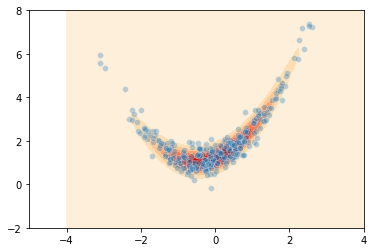

In [259]:
x1 = torch.linspace(-4, 4, 100)
x2 = torch.linspace(-2, 9, 100)
X1, X2 = torch.meshgrid([x1, x2])
d0 = BananaGaussian(1.15, 0.9)  # more extreme case try (1.15, 1.96)
P = torch.exp(d0.log_prob(torch.stack([X1, X2], dim=-1)))
_, ax = plt.subplots(1, 1)
ax.contourf(X1, X2, P, cmap='OrRd', )
ax.set_ylim(-2, 8)
dist_samples = d0.sample((300,))
sns.scatterplot(dist_samples[:, 0], dist_samples[:, 1], alpha=0.3, ax=ax);

In [260]:
def model(a, b, rho=0.9):
    pyro.sample('x', BananaGaussian(a, b, rho))

### Visalize Potential Function

In [261]:
from pyro.infer.mcmc.util import initialize_model

In [262]:
_, get_potential_fn, _, _ = initialize_model(model, model_args=(1.15, 0.9))

In [263]:
x = torch.tensor([0., 1.])
print(d0.log_prob(x))
print(get_potential_fn({'x': x}))

tensor(-1.1335)
tensor(1.1335)


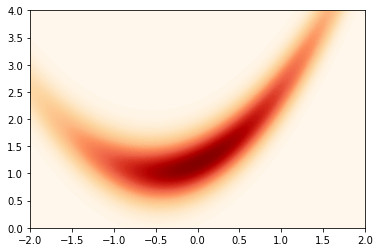

In [264]:
x1 = torch.linspace(-2, 2, 100)
x2 = torch.linspace(0, 4, 100)
xm1, xm2 = torch.meshgrid([x1, x2])
# Inefficient; should be easy to add dim arg to get_potential_fn
pm = [get_potential_fn({'x': torch.stack([xm1[i, j], xm2[i, j]])}) 
      for i in range(100) for j in range(100)]
pm = torch.exp(-torch.stack(pm).reshape(100, 100))
plt.contourf(xm1, xm2, pm, cmap='OrRd', levels=100);

## Run Vanilla HMC

In [265]:
pyro.set_rng_seed(0)

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, warmup_steps=500, num_samples=1000)
mcmc.run(1.15, 0.9)
mcmc.summary()

Sample: 100%|██████████| 1500/1500 [00:17, 83.69it/s, step size=2.01e-01, acc. prob=0.877] 


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      x[0]     -0.18      1.05     -0.11     -1.85      1.55     97.06      1.00
      x[1]      1.85      1.03      1.58      0.48      3.55    162.93      1.00

Number of divergences: 4


In [266]:
vanilla_samples = mcmc.get_samples()['x'].detach().numpy()

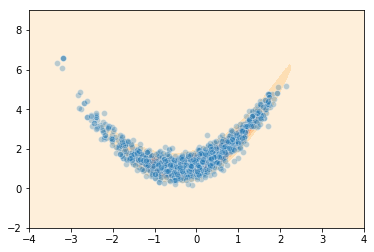

In [267]:
f, ax = plt.subplots(1, 1)
ax.contourf(X1, X2, P, cmap='OrRd')
sns.scatterplot(vanilla_samples[:, 0], vanilla_samples[:, 1], alpha=0.3, ax=ax);

## Fit a diagonal normal autoguide

In [268]:
from functools import partial

from torch import nn

from pyro.distributions.transforms import iterated, AffineTransform
from pyro.infer.autoguide import AutoContinuous, AutoNormalizingFlow
from pyro.infer.autoguide.initialization import init_to_median, init_to_sample
from pyro.nn import PyroParam

In [269]:
# write in terms of TransformedDistribution to run neutra

class AutoDiagonalNormal(AutoContinuous):
    def __init__(self, model, init_loc_fn=init_to_median, init_scale=0.1):
        if not isinstance(init_scale, float) or not (init_scale > 0):
            raise ValueError("Expected init_scale > 0. but got {}".format(init_scale))
        self._init_scale = init_scale
        super().__init__(model, init_loc_fn=init_loc_fn)

    def _setup_prototype(self, *args, **kwargs):
        super()._setup_prototype(*args, **kwargs)
        # Initialize guide params
        self.loc = nn.Parameter(self._init_loc())
        self.scale = PyroParam(self.loc.new_full((self.latent_dim,), self._init_scale),
                               constraints.positive)

    def get_posterior(self, *args, **kwargs):
        """
        Returns a diagonal Normal posterior distribution.
        """
        transform = AffineTransform(self.loc, self.scale)
        return dist.TransformedDistribution(dist.Normal(0., 1.).expand([self.latent_dim]).to_event(1), 
                                            transform)

    def _loc_scale(self, *args, **kwargs):
        return self.loc, self.scale


In [270]:
pyro.clear_param_store()
pyro.set_rng_seed(1)

adam = optim.Adam({'lr': 1e-2})
guide = AutoDiagonalNormal(model, init_scale=0.05, init_loc_fn=init_to_median)
svi = SVI(model, guide, adam, Trace_ELBO())
for i in range(10000):
    loss = svi.step(1.15, 0.9)
    if i % 500 == 0:
        print("[{}]Elbo loss = {:.2f}".format(i, loss))

[0]Elbo loss = 9.66
[500]Elbo loss = 0.53
[1000]Elbo loss = 1.50
[1500]Elbo loss = 0.74
[2000]Elbo loss = -0.31
[2500]Elbo loss = 0.18
[3000]Elbo loss = 1.56
[3500]Elbo loss = 0.32
[4000]Elbo loss = 0.70
[4500]Elbo loss = 0.62
[5000]Elbo loss = 0.36
[5500]Elbo loss = 1.36
[6000]Elbo loss = 0.38
[6500]Elbo loss = 0.14
[7000]Elbo loss = 2.61
[7500]Elbo loss = 0.90
[8000]Elbo loss = 0.68
[8500]Elbo loss = 1.63
[9000]Elbo loss = 0.48
[9500]Elbo loss = 0.80


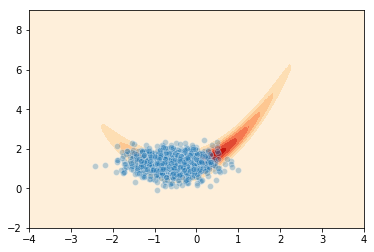

In [271]:
with pyro.plate('N', 1000):
    guide_samples = guide()['x'].detach().numpy()

f, ax = plt.subplots(1, 1)
ax.contourf(X1, X2, P, cmap='OrRd')
sns.scatterplot(guide_samples[:, 0], guide_samples[:, 1], alpha=0.3, ax=ax);

### NeutraHMC using a Diagonal Normal Autoguide

In [272]:
guide.requires_grad_(False)
neutra = NeuTraReparam(guide)
neutra_model = poutine.reparam(model, config=lambda _: neutra)

In [273]:
pyro.set_rng_seed(2)

nuts_kernel = NUTS(neutra_model)
mcmc = MCMC(nuts_kernel, 500, 1000)
mcmc.run(1.15, 0.9)
mcmc.summary()

Sample: 100%|██████████| 1500/1500 [00:19, 78.58it/s, step size=2.61e-01, acc. prob=0.889]


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
x_shared_latent[0]      0.88      1.47      0.84     -1.05      3.62     75.58      1.00
x_shared_latent[1]      0.48      1.50      0.06     -1.54      2.79    127.11      1.03

Number of divergences: 0


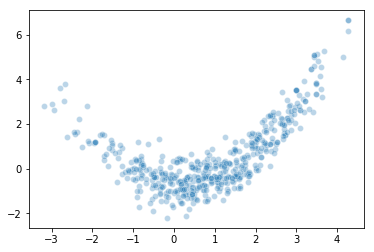

In [274]:
zs = mcmc.get_samples()["x_shared_latent"]
sns.scatterplot(zs[:, 0], zs[:, 1], alpha=0.3);

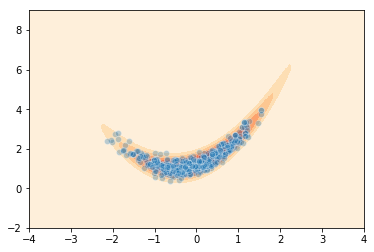

In [275]:
samples = neutra.transform_sample(zs)
samples = samples['x'].detach().numpy()

f, ax = plt.subplots(1, 1)
ax.contourf(X1, X2, P, cmap='OrRd')
sns.scatterplot(samples[:, 0], samples[:, 1], alpha=0.3, ax=ax);

### Visualize the potential energy

In [235]:
_, get_potential_fn, _, _ = initialize_model(neutra_model, model_args=(1.15, 0.9))

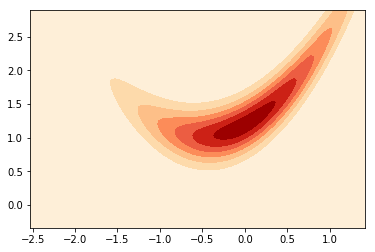

In [238]:
x1 = torch.linspace(-4, 4, 100)
x2 = torch.linspace(-4, 4, 100)
xm1, xm2 = torch.meshgrid([x1, x2])
# Inefficient; should be easy to add dim arg to get_potential_fn
pm = [get_potential_fn({'x_shared_latent': torch.stack([xm1[i, j], xm2[i, j]])}) 
      for i in range(100) for j in range(100)]
pm = torch.exp(-torch.stack(pm).reshape(100, 100))
transform = guide.get_posterior().transforms[0]
tx = transform(torch.stack([xm1, xm2], -1))
xm1, xm2 = tx[..., 0], tx[..., 1]
plt.contourf(xm1, xm2, pm, cmap='OrRd');

In [206]:
xm1

tensor([[-1.5424, -1.5424, -1.5424,  ..., -1.5424, -1.5424, -1.5424],
        [-1.5224, -1.5224, -1.5224,  ..., -1.5224, -1.5224, -1.5224],
        [-1.5025, -1.5025, -1.5025,  ..., -1.5025, -1.5025, -1.5025],
        ...,
        [ 0.3907,  0.3907,  0.3907,  ...,  0.3907,  0.3907,  0.3907],
        [ 0.4107,  0.4107,  0.4107,  ...,  0.4107,  0.4107,  0.4107],
        [ 0.4306,  0.4306,  0.4306,  ...,  0.4306,  0.4306,  0.4306]])

## Fit a BNAF autoguide

In [243]:
from pyro.distributions.transforms import block_autoregressive

In [244]:
pyro.clear_param_store()
pyro.set_rng_seed(1)

adam = optim.Adam({'lr': 1e-2})
guide = AutoNormalizingFlow(model, partial(iterated, 1, block_autoregressive))
svi = SVI(model, guide, adam, Trace_ELBO())
for i in range(6000):
    loss = svi.step(1.15, 0.9)
    if i % 500 == 0:
        print("[{}]Elbo loss = {:.2f}".format(i, loss))

[0]Elbo loss = -0.24
[500]Elbo loss = 0.83
[1000]Elbo loss = 0.27
[1500]Elbo loss = 0.31
[2000]Elbo loss = 0.17
[2500]Elbo loss = 0.20
[3000]Elbo loss = 2.32
[3500]Elbo loss = 0.45
[4000]Elbo loss = -0.09
[4500]Elbo loss = -0.11
[5000]Elbo loss = 0.59
[5500]Elbo loss = 0.40


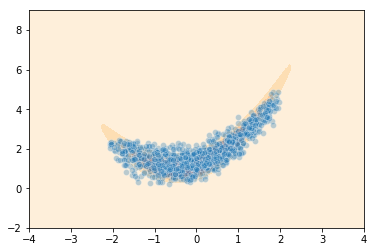

In [245]:
with pyro.plate('N', 1000):
    guide_samples = guide()['x'].detach().numpy()

f, ax = plt.subplots(1, 1)
ax.contourf(X1, X2, P, cmap='OrRd')
sns.scatterplot(guide_samples[:, 0], guide_samples[:, 1], alpha=0.3, ax=ax);

## Sample from NeutraHMC

In [253]:
guide = guide.requires_grad_(False)
neutra = NeuTraReparam(guide)
neutra_model = poutine.reparam(model, config=lambda _: neutra)

In [247]:
pyro.set_rng_seed(2)


nuts_kernel = NUTS(neutra_model)
mcmc = MCMC(nuts_kernel, 500, 1000)
mcmc.run(1.15, 0.9)
mcmc.summary()

Sample: 100%|██████████| 1500/1500 [00:36, 40.63it/s, step size=6.46e-01, acc. prob=0.884]


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
x_shared_latent[0]      0.02      0.07      0.02     -0.10      0.11    235.37      1.00
x_shared_latent[1]     -0.90      3.60     -0.32     -6.09      5.02    255.98      1.00

Number of divergences: 0


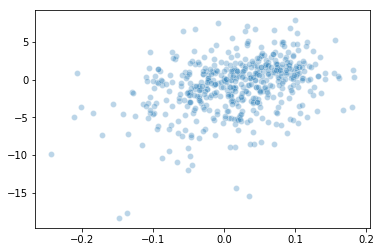

In [248]:
zs = mcmc.get_samples()["x_shared_latent"]
sns.scatterplot(zs[:, 0], zs[:, 1], alpha=0.3);

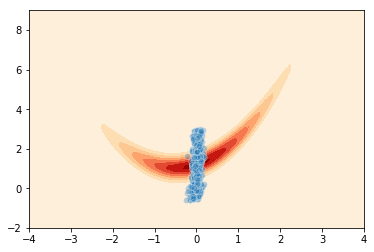

In [249]:
zs = mcmc.get_samples()["x_shared_latent"]
samples = neutra.transform_sample(zs)
zs = zs.detach().numpy()
samples = samples['x'].detach().numpy()

f, ax = plt.subplots(1, 1)
ax.contourf(X1, X2, P, cmap='OrRd')
sns.scatterplot(samples[:, 0], samples[:, 1], alpha=0.3, ax=ax);

### Visualize the potential energy

In [250]:
from pyro.infer.mcmc.util import initialize_model

In [254]:
_, get_potential_fn, _, _ = initialize_model(neutra_model, model_args=(1.15, 0.9))

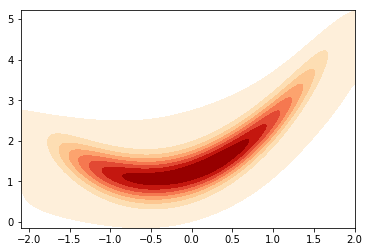

In [255]:
x1 = torch.linspace(-4, 4, 100)
x2 = torch.linspace(-4, 4, 100)
xm1, xm2 = torch.meshgrid([x1, x2])
# Inefficient; should be easy to add dim arg to get_potential_fn
pm = [get_potential_fn({'x_shared_latent': torch.stack([xm1[i, j], xm2[i, j]])}) 
      for i in range(100) for j in range(100)]
pm = torch.exp(-torch.stack(pm).reshape(100, 100))
transform = guide.get_posterior().transforms[0]
tx = transform(torch.stack([xm1, xm2], -1))
xm1, xm2 = tx[..., 0], tx[..., 1]
plt.contourf(xm1, xm2, pm, cmap='OrRd');